# **KLASIFIKASI MOBIL AMBULANCE & NON-AMBULANCE**


## IMPORT LIBRARY

In [1]:
import io
import json
import seaborn as sns
import os
import shutil
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import Xception
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ReLU, BatchNormalization

## DATA PREPARATION

### Load Dataset

In [2]:
!unzip "Dataset Kendaraan.zip"

Archive:  Dataset Kendaraan.zip
  inflating: carsdataset/ambulance/008CY5SRHBLM.jpg  
  inflating: carsdataset/ambulance/00DWEUY37A15.jpg  
  inflating: carsdataset/ambulance/0178DFJL75X3.jpg  
  inflating: carsdataset/ambulance/01TAD3630VU8.jpg  
  inflating: carsdataset/ambulance/038TI986DAFR.jpg  
  inflating: carsdataset/ambulance/03YJ60A08EMM.jpg  
  inflating: carsdataset/ambulance/04EN6KIM1W6D.jpg  
  inflating: carsdataset/ambulance/051540V1DZV0.jpg  
  inflating: carsdataset/ambulance/05O4RQIF5CSJ.jpg  
  inflating: carsdataset/ambulance/06B5FJE2HA99.jpg  
  inflating: carsdataset/ambulance/06D206F0OS0R.jpg  
  inflating: carsdataset/ambulance/06WAUAXURDC6.jpg  
  inflating: carsdataset/ambulance/08YYYQAX44JF.jpg  
  inflating: carsdataset/ambulance/0ADMGPUBCCPE.jpg  
  inflating: carsdataset/ambulance/0AK3AJ1RFGF6.jpg  
  inflating: carsdataset/ambulance/0AL642VPYDA4.jpg  
  inflating: carsdataset/ambulance/0AQOQ3HKLU2A.jpg  
  inflating: carsdataset/ambulance/0AXHYXBNS4UP.jp

###Analisis Dataset: Jumlah dan Resolusi Gambar

In [3]:

def cek_images_resolution(dataset_path):
    """Cek resolusi dan jumlah gambar per kelas pada dataset"""

    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(dataset_path):
        subdir_path = os.path.join(dataset_path, subdir)

        if not os.path.isdir(subdir_path):
            continue

        # ambil file gambar
        image_files = [
            f for f in os.listdir(subdir_path)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

        num_images = len(image_files)
        print(f"{subdir}: {num_images} images")
        total_images += num_images

        # cek resolusi tiap gambar
        class_sizes = set()
        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            try:
                with Image.open(img_path) as img:
                    class_sizes.add(img.size)
            except Exception as e:
                print(f"  Error membaca {img_file}: {e}")

        for size in class_sizes:
            print(f"  - Resolution: {size}")
            unique_sizes.add(size)

        print("---------------")

    print(f"\nTotal images: {total_images}")
    print(f"Unique resolutions found: {len(unique_sizes)}")
    return total_images, unique_sizes


# Panggil fungsi untuk dataset
total_img, resolutions = cek_images_resolution('carsdataset')

ambulance: 2121 images
  - Resolution: (256, 256)
---------------
noambulance: 2628 images
  - Resolution: (322, 157)
  - Resolution: (206, 244)
  - Resolution: (205, 246)
  - Resolution: (315, 160)
  - Resolution: (430, 117)
  - Resolution: (225, 224)
  - Resolution: (251, 188)
  - Resolution: (328, 154)
  - Resolution: (326, 154)
  - Resolution: (201, 251)
  - Resolution: (177, 284)
  - Resolution: (186, 271)
  - Resolution: (168, 299)
  - Resolution: (276, 183)
  - Resolution: (310, 157)
  - Resolution: (324, 156)
  - Resolution: (297, 169)
  - Resolution: (219, 231)
  - Resolution: (337, 150)
  - Resolution: (259, 194)
  - Resolution: (207, 156)
  - Resolution: (331, 152)
  - Resolution: (334, 151)
  - Resolution: (280, 180)
  - Resolution: (266, 190)
  - Resolution: (365, 138)
  - Resolution: (267, 189)
  - Resolution: (252, 200)
  - Resolution: (272, 185)
  - Resolution: (220, 147)
  - Resolution: (258, 195)
  - Resolution: (287, 176)
  - Resolution: (190, 170)
  - Resolution: (2

###Visualisasi Distribusi Dataset

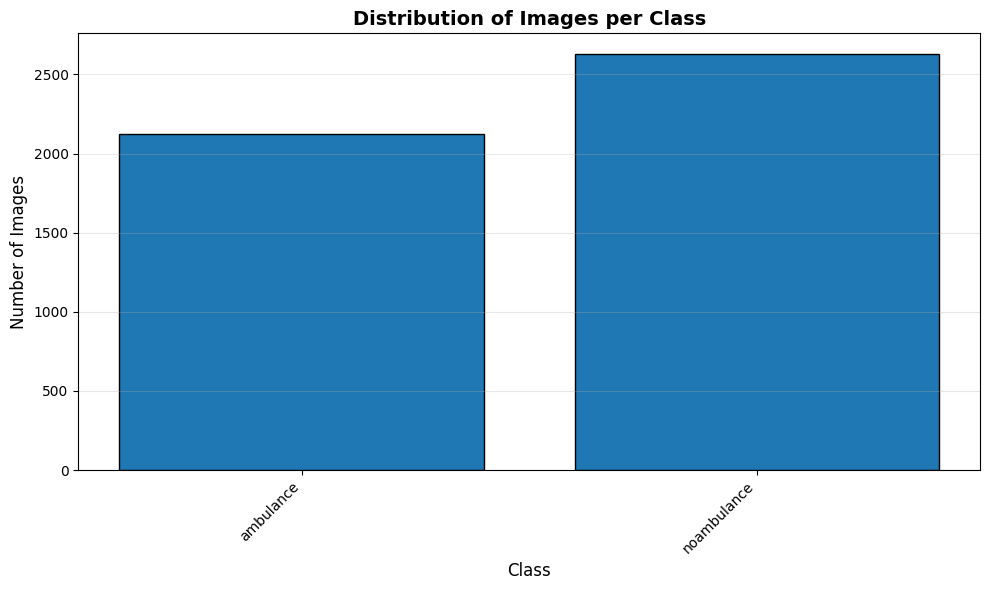

In [4]:
dataset_path = 'carsdataset'
classes = os.listdir(dataset_path)

# Menghitung jumlah gambar per kelas
class_counts = {}
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    class_counts[cls] = len(
        [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    )

# Plot distribusi gambar
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), edgecolor='black')
plt.title('Distribution of Images per Class', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## DATA PREPROCESSING

### Pembagian Dataset

In [5]:
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

out_dir = 'data_split'
os.makedirs(out_dir, exist_ok=True)

In [6]:
# Mulai pembagian dataset
for class_name in os.listdir(dataset_path):
    class_src = os.path.join(dataset_path, class_name)

    # Lewati jika bukan folder kelas
    if not os.path.isdir(class_src):
        continue

    # Ambil semua file gambar dari kelas
    class_files = [
        os.path.join(class_src, f)
        for f in os.listdir(class_src)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

    # Split Train vs Temp
    train_files, temp_files = train_test_split(
        class_files, train_size=train_ratio, random_state=42, shuffle=True
    )

    # Split temp menjadi validation dan test
    rel_val = val_ratio / (val_ratio + test_ratio)
    val_files, test_files = train_test_split(
        temp_files, train_size=rel_val, random_state=42
    )

    # Copy file ke masing-masing folder
    for subset, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
        target_dir = os.path.join(out_dir, subset, class_name)
        os.makedirs(target_dir, exist_ok=True)

        for src in file_list:
            shutil.copy2(src, os.path.join(target_dir, os.path.basename(src)))

    print(f"{class_name}: Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}")

print(f"\nDataset berhasil dipisahkan ke folder: {out_dir}")

ambulance: Train=1484, Val=318, Test=319
noambulance: Train=1839, Val=394, Test=395

Dataset berhasil dipisahkan ke folder: data_split


In [7]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = os.path.join(out_dir, 'train')
val_dir = os.path.join(out_dir, 'val')
test_dir = os.path.join(out_dir, 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)
training_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_dataset = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

testing_dataset = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(training_dataset.class_indices.keys())
print(f"\nKelas dataset: {class_names}")
print(f"Jumlah kelas: {len(class_names)}")

Found 3323 images belonging to 2 classes.
Found 712 images belonging to 2 classes.
Found 714 images belonging to 2 classes.

Kelas dataset: ['ambulance', 'noambulance']
Jumlah kelas: 2


## MODELLING

In [8]:
model = models.Sequential([
    Xception(weights='imagenet', include_top=False, input_shape=(224,224,3)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(len(class_names), activation='softmax')
])

model.layers[0].trainable = False

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)       │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 3, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 1, 1, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 21,806,954 (83.19 MB)

 Trainable params: 943,810 (3.60 MB)

 Non-trainable params: 20,863,144 (79.59 MB)

###Model Compilation

In [9]:
learning_rate = 0.0001
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Training

In [10]:
callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
]

history = model.fit(
    training_dataset,
    epochs=15,
    validation_data=validation_dataset,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.5558 - loss: 1.0710
Epoch 1: val_accuracy improved from -inf to 0.55899, saving model to best_model.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 120s 833ms/step - accuracy: 0.5564 - loss: 1.0693 - val_accuracy: 0.5590 - val_loss: 0.6415 - learning_rate: 1.0000e-04
Epoch 2/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.7773 - loss: 0.4799
Epoch 2: val_accuracy improved from 0.55899 to 0.97753, saving model to best_model.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 49s 472ms/step - accuracy: 0.7778 - loss: 0.4791 - val_accuracy: 0.9775 - val_loss: 0.2893 - learning_rate: 1.0000e-04
Epoch 3/15
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9104 - loss: 0.2425
Epoch 3: val_accuracy improved from 0.97753 to 0.98315, saving model to best_model.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 471ms/step - accuracy: 0.9105 - loss: 0.2422 - val_accuracy: 0.9831 - val_loss: 0.0753 - learning_rate: 1.0000e-04
Epoch 4/15
104/104 ━━━━━━━━

### Visualisasi

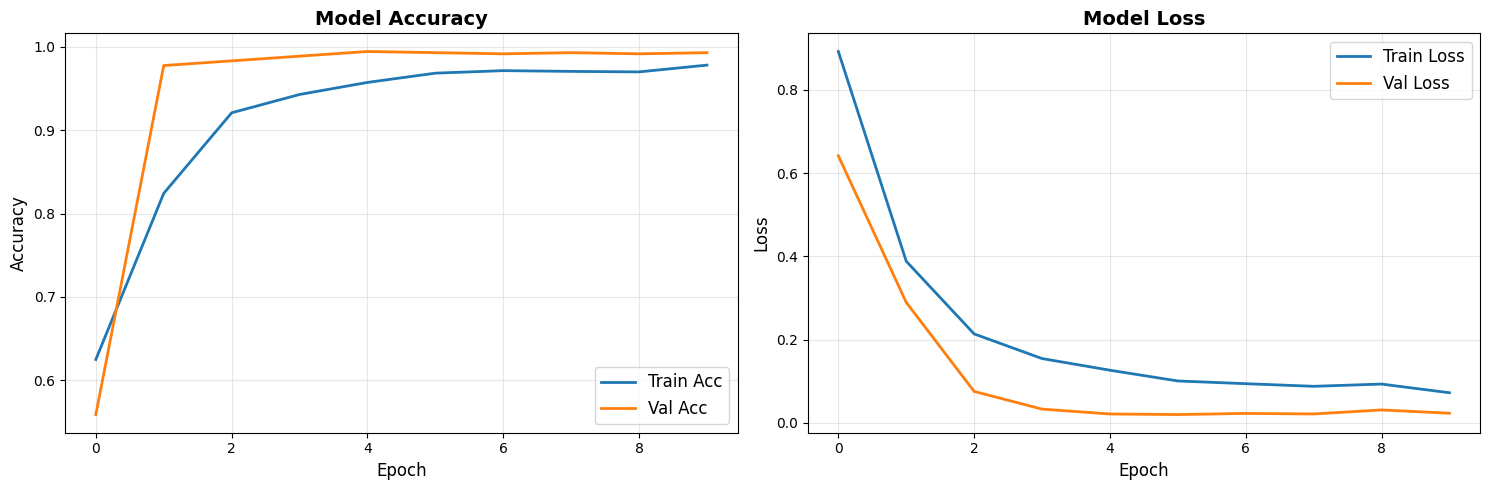

In [11]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
plt.legend(fontsize=12)
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.legend(fontsize=12)
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Evaluasi

In [12]:
loss, accuracy = model.evaluate(testing_dataset, verbose=1)
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1] if 'val_accuracy' in history.history else None

print(f"\nTrain Accuracy      : {train_acc*100:.2f}%")
if val_acc is not None:
    print(f"Validation Accuracy : {val_acc*100:.2f}%")
print(f"Test Accuracy       : {accuracy*100:.2f}%")

23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 653ms/step - accuracy: 0.9910 - loss: 0.0251

Train Accuracy      : 97.80%
Validation Accuracy : 99.30%
Test Accuracy       : 99.30%


In [13]:
# Classification report
y_pred_probs = model.predict(testing_dataset, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = testing_dataset.classes

print("CLASSIFICATION REPORT")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 345ms/step
CLASSIFICATION REPORT
              precision    recall  f1-score   support

   ambulance       0.99      0.99      0.99       319
 noambulance       0.99      0.99      0.99       395

    accuracy                           0.99       714
   macro avg       0.99      0.99      0.99       714
weighted avg       0.99      0.99      0.99       714



## Konversi & Penyimpanan Model

In [14]:
import os
import shutil
import tensorflow as tf

# Pastikan TensorFlow.js sudah terinstall sebelum proses
!pip install -q tensorflowjs

submission_dir = 'submission'
os.makedirs(submission_dir, exist_ok=True)

best_model_path = 'best_model.keras'

if os.path.exists(best_model_path):
    print(f"\nLoading best model dari: {best_model_path}")
    best_model = tf.keras.models.load_model(best_model_path)
else:
    print("\nMenggunakan model terakhir dari training")
    best_model = model


# ==============================================
# 1. Save as SavedModel Format
# ==============================================
print("\n[1/3] Menyimpan ke SavedModel format...")

saved_model_dir = os.path.join(submission_dir, 'saved_model')
if os.path.exists(saved_model_dir):
    shutil.rmtree(saved_model_dir)

best_model.export(saved_model_dir)

print(f"✓ SavedModel berhasil disimpan di: {saved_model_dir}")
print("  - saved_model.pb")
print("  - variables/")


# ==============================================
# 2. Save as TFLite Format
# ==============================================
print("\n[2/3] Menyimpan ke TFLite format...")

tflite_dir = os.path.join(submission_dir, 'tflite')
os.makedirs(tflite_dir, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

tflite_path = os.path.join(tflite_dir, 'model.tflite')
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f"✓ TFLite model tersimpan: {tflite_path}")
print(f"  Ukuran: {os.path.getsize(tflite_path)/1024/1024:.2f} MB")

label_path = os.path.join(tflite_dir, 'label.txt')
with open(label_path, 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

print(f"✓ Label file berhasil disimpan di: {label_path}")
print(f"  Classes: {', '.join(class_names)}")


# ==============================================
# 3. Save as TensorFlow.js Format
# ==============================================
print("\n[3/3] Menyimpan ke TensorFlow.js format...")

import tensorflowjs as tfjs

tfjs_dir = os.path.join(submission_dir, 'tfjs_model')

if os.path.exists(tfjs_dir):
    shutil.rmtree(tfjs_dir)

tfjs.converters.save_keras_model(best_model, tfjs_dir)

print(f"✓ TensorFlow.js model berhasil disimpan di: {tfjs_dir}")
print("  - model.json")
print("  - weights shard files (.bin)")


print("\nSemua format model berhasil dibuat!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.11.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.

Loading best model dari: best_model.keras

[1/3] Menyimpan ke SavedModel format...
Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Capture

failed to lookup keras version from the file,
    this is likely a weight only file
✓ TensorFlow.js model berhasil disimpan di: submission/tfjs_model
  - model.json
  - weights shard files (.bin)

Semua format model berhasil dibuat!


## Inference (OPTIONAL)


Loading SavedModel untuk inference...

✓ SavedModel berhasil dimuat!

Silakan unggah gambar:


Saving car.jpg to car.jpg


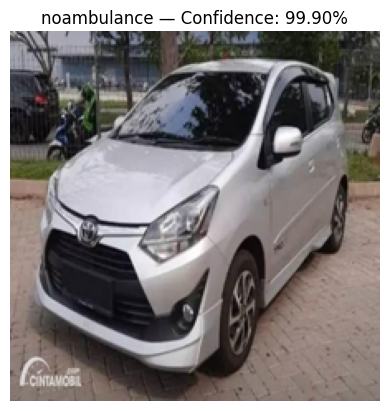

In [15]:
from google.colab import files

print("\nLoading SavedModel untuk inference...")

inference_model = tf.keras.layers.TFSMLayer('/content/submission/saved_model', call_endpoint='serve')
print("\n\u2713 SavedModel berhasil dimuat!")

def preprocess_image(path, size=(224, 224)):
    img = Image.open(path).convert("RGB")
    img = img.resize(size)
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0), img

print("\nSilakan unggah gambar:")
uploaded = files.upload()

for file_name in uploaded.keys():
    img_tensor, img_display = preprocess_image(io.BytesIO(uploaded[file_name]))
    preds = inference_model(img_tensor)[0]
    pred_idx = np.argmax(preds)
    pred_label = class_names[pred_idx]
    confidence = preds[pred_idx]

    plt.imshow(img_display)
    plt.title(f"{pred_label} \u2014 Confidence: {confidence:.2%}")
    plt.axis("off")
    plt.show()

##Requirement.txt

In [16]:
!pip freeze > requirements.txt